# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Зависимости

In [232]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Функции и константы

<a id='func_const'></a>

In [233]:
STATE = np.random.RandomState(12345) # используется для генерации различных семплов
BARREL_RUB = 450 
NUM_OF_OBJECTS = 200 # итоговое количество исследуемых месторождений
BUDGET = 1e10

In [234]:
def read_data(url:str, info:bool=False):
    """
    Чтение датасета и вывод иноформации о нём
    """
    df = pd.read_csv(url)
    if info:
        df.info()
        df['product'].hist()
        plt.xlabel("Барели, тыс.")
        display('Корреляция')
        display(df.corr())
        display('Примеры')
        display(df.head())
    return df

In [235]:
def normalize(df:pd.DataFrame):
    scaler = StandardScaler()
    scaler.fit(df)
    return pd.DataFrame(scaler.transform(df), columns=df.columns)

In [236]:
def split_ds(df:pd.DataFrame):
    target = df['product']
    features = df.drop(columns=['product', 'id'], axis=1)
    return train_test_split(features, target, random_state=12345, test_size=0.25)

In [237]:
def model_train_pred(features_train,features_valid,target_train,target_valid, print_res:bool = False):
    model = LinearRegression()
    model.fit(normalize(features_train),target_train)
    preds = model.predict(normalize(features_valid))
    mean_pred = pd.Series(preds).mean()
    preds_target = pd.DataFrame(data={"pred": preds, 'target':target_valid})
    if print_res:
        display(f'Среднее от предсказаний: {mean_pred}')
        display(f'RMSE: {mean_squared_error(target_valid, preds) ** 0.5}')
    return preds_target, mean_pred

In [238]:
def calc_income(amount=0):
    try:
        return int(sum(amount) * BARREL_RUB * 1e3)
    except TypeError:
        return int(amount * BARREL_RUB * 1e3)

In [239]:
def calc_profit_risks(preds_target:pd.DataFrame, costs):
    samples = []
    for i in range(1000):
        sample = preds_target.sample(n=500, replace=True, random_state=STATE)
        sample = sample.sort_values('pred', ascending=False)[:NUM_OF_OBJECTS]
        samples.append(calc_income((sample['target'] - costs).sum()))
    samples = pd.Series(samples)
    samples.hist()
    plt.xlabel('Прибыль')
    interval = samples.quantile(q=0.025), samples.quantile(q=0.975)
    display(f"Средняя прибыль: {int(sum(samples) / len(samples))} руб.")
    display(f"Доверительный интервал в 95%: {int(interval[0])} руб., {int(interval[1])} руб.")
    display(f"Доля отрицательной прибыли: {samples[samples < 0].count() / len(samples)}")

## Загрузка и подготовка данных

[read_data](#func_const)

[split_ds](#func_const)

В фичи не следует включать признак **id**.

Обучающая выборка относится к валидационной как 3:1. В валидационную выборку входит 25000 примеров.

Целевой признак в первом регионе распределён нормально. Признак f2 коррелирует с целевым.

Целевой признак во втором регионе распределён константно в диапазоне от 20 до 120 тыс.б., по краям выбросы. Признак f2 практически линейно зависим от целевого.

Целевой признак в третьем регионе распределён нормально. Признак f2 коррелирует с целевым.

### Регион 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Корреляция'

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


'Примеры'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


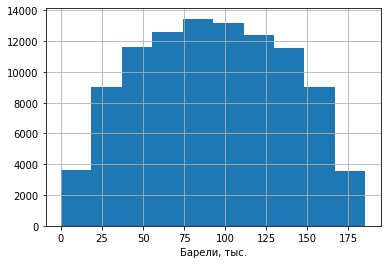

In [240]:
region_0 = read_data('/datasets/geo_data_0.csv', info=True)

In [241]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_ds(region_0)
features_train_0.shape, features_valid_0.shape

((75000, 3), (25000, 3))

### Регион 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Корреляция'

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


'Примеры'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


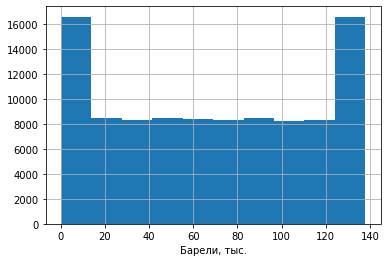

In [242]:
region_1 = read_data('/datasets/geo_data_1.csv', info=True)

In [243]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_ds(region_1)
features_train_1.shape, features_valid_1.shape

((75000, 3), (25000, 3))

### Регион 3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'Корреляция'

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


'Примеры'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


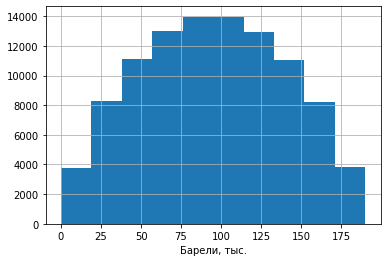

In [244]:
region_2 = read_data('/datasets/geo_data_2.csv', info=True)

In [245]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_ds(region_2)
features_train_2.shape, features_valid_2.shape

((75000, 3), (25000, 3))

## Обучение и проверка модели

[model_train_pred](#func_const)

### Регион 1

In [246]:
preds_target_0, mean_barell_0 = model_train_pred(features_train_0, features_valid_0, target_train_0, target_valid_0, True)

'Среднее от предсказаний: 92.64046775305692'

'RMSE: 37.58010943632562'

### Регион 2

In [247]:
preds_target_1, mean_barell_1 = model_train_pred(features_train_1, features_valid_1, target_train_1, target_valid_1, True)

'Среднее от предсказаний: 68.85895465854666'

'RMSE: 0.910164709305544'

### Регион 3

In [248]:
preds_target_2, mean_barell_2 = model_train_pred(features_train_2, features_valid_2, target_train_2, target_valid_2, True)

'Среднее от предсказаний: 95.03858906371521'

'RMSE: 40.0303627970992'

## Подготовка к расчёту прибыли

In [249]:
min_amount = BUDGET / (BARREL_RUB * 1e3 * NUM_OF_OBJECTS)
min_amount

111.11111111111111

Необходимый средний объём добычи для окупа - 111112 б.

### Регион 1

In [250]:
f'Среднее предсказаний добычи составляет {round(mean_barell_0 / min_amount * 100, 1)} % от минимального среднего объёма.'

'Среднее предсказаний добычи составляет 83.4 % от минимального среднего объёма.'

### Регион 2

In [251]:
f'Среднее предсказаний добычи составляет {round(mean_barell_1 / min_amount * 100,1) } % от минимального среднего объёма.'

'Среднее предсказаний добычи составляет 62.0 % от минимального среднего объёма.'

### Регион 3

In [252]:
f'Среднее предсказаний добычи составляет {round(mean_barell_2 / min_amount * 100,1)} % от минимального среднего объёма.'

'Среднее предсказаний добычи составляет 85.5 % от минимального среднего объёма.'

### Промежуточные выводы

Максимальное среднее предсказаний добычи в третьем и первом регионах. Более вероятно, что в этих регионах будет наблюдаться относительно высокая средняя прибыль.

## Расчёт прибыли и рисков 


[calc_income](#func_const)

[calc_profit_risks](#func_const)

### Регион 1

'Средняя прибыль: 395865511 руб.'

'Доверительный интервал в 95%: -108954224 руб., 909105814 руб.'

'Доля отрицательной прибыли: 0.07'

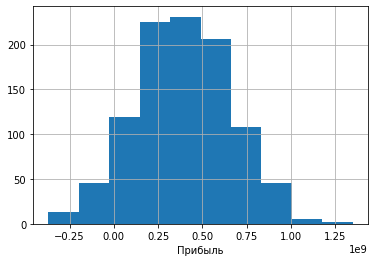

In [253]:
calc_profit_risks(preds_target_0, min_amount)

### Регион 2

'Средняя прибыль: 461157247 руб.'

'Доверительный интервал в 95%: 78050810 руб., 862952060 руб.'

'Доля отрицательной прибыли: 0.007'

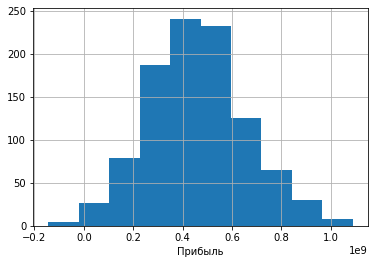

In [254]:
calc_profit_risks(preds_target_1, min_amount)

### Регион 3

'Средняя прибыль: 392990469 руб.'

'Доверительный интервал в 95%: -112227624 руб., 934562913 руб.'

'Доля отрицательной прибыли: 0.065'

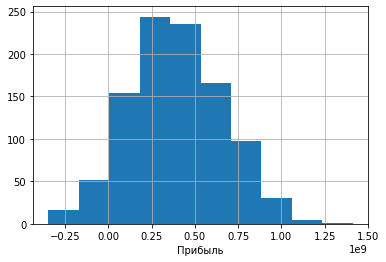

In [255]:
calc_profit_risks(preds_target_2, min_amount)

## Итоги

Значение риска меньше 2.5% достигается только во втором регионе, также в нём максимальная средняя прибыль.

Вывод - скважину нужно бурить во втором регионе.